## [1] Import Libraries

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import rasterio as rio
import warnings
warnings.filterwarnings("ignore")

## [2] Set Up Masks

This sections creates masks for the MEASURES 2012-2013 mosaic no data regions, so that we can mask these out of the strain rate data which would otherwise have strange edge effects where the velocity data stops existing. 

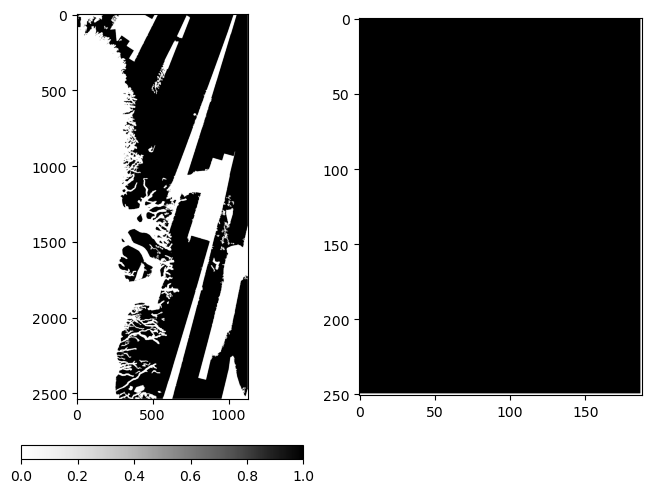

In [2]:
# Directories with velocities for training areas on the west coast of Greenland
vel_file_w = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\Velocity\\greenland_vel_mosaic500_2012_2013_vx_training.tif"
vel_file_e = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\Velocity\\greenland_vel_mosaic500_2012_2013_vx_NE.tif"

# Load the M12 velocity file for the west coast of Greenland and generate a mask to remove areas where the velocity data is not valid
dataset = rio.open(vel_file_w)
M12_velocity = dataset.read(1)
dataset.close()
vel_mask_w = np.zeros(M12_velocity.shape)
for i in range(0,vel_mask_w.shape[0]):
    for j in range(0,vel_mask_w.shape[1]):
        if M12_velocity[i,j] != -2e9:
            vel_mask_w[i,j] = 1.

# Load the M12 velocity file for the east coast of Greenland and generate a mask to remove areas where the velocity data is not valid
dataset = rio.open(vel_file_e)
M12_velocity = dataset.read(1)
dataset.close()
vel_mask_e = np.zeros(M12_velocity.shape)
for i in range(0,vel_mask_e.shape[0]):
    for j in range(0,vel_mask_e.shape[1]):
        if M12_velocity[i,j] != -2e9:
            vel_mask_e[i,j] = 1.

# Plot velocity masks for a sanity check
fig, (ax1, ax2) = plt.subplots(1,2,layout="constrained")
im = ax1.imshow(vel_mask_w, cmap='Greys')
ax2.imshow(vel_mask_e, cmap='Greys')
cbar = fig.colorbar(im, location='bottom')
plt.show()

## [3] Run the Parameter Optimization

In [3]:
# Directories with the strain rates
strain_dir_w = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\StrainRate\\"
strain_dir_e = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\StrainRateNE\\"
# Directory with the surface temperatures
temp_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\RACMOTraining\\"
# Directory with the crevasse/no crevasse observations
crev_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\TrainingData\\"
# Directory with the boundaries of the test data that we will withold from training
test_dir =  "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\TestSet\\"

# List of strain map experiment names
strain_experiments = ["Exp1", "Exp2", "Exp3", "Exp4", "Exp5", "Exp6", "Exp7", 
                      "Exp8", "Exp9", "Exp10", "Exp11", "Exp12", "Exp13", "Exp14", 
                      "Exp15", "Exp16", "Exp17", "Exp18", "Exp19", "Exp20", "Exp21",
                      "Exp22", "Exp23", "Exp24", "Exp25", "Exp26", "Exp27", "Exp28"]
# List of velocity sources to test
velocity_maps = ["MAvg", "M12", "ILAvg"]
# List of temperature average time periods to test
temp_maps = ["Decadal", "Annual", "DJF", "JJA"]

# Uncomment and edit to generate results for a single experiment, instead of the entire optimization ensemble
#strain_experiments = ["Exp18"]
#velocity_maps = ["MAvg"]
#temp_maps = ["Annual"]

# Cuffey and Patterson Constants for Ice Viscosity Model
A_star = 3.5e-25        # Pa^-3s^-1
T_start = 263.0         # K
R = 8.314               # J mol^-1 K^-1
Qc = 60e3               # J mol^-1
Qc2 = 115e3             # J mol^-1
n = 3.

f1_results = np.zeros((len(velocity_maps),len(strain_experiments),len(temp_maps)))           # Save model F1 score
tensile_strength = np.zeros((len(velocity_maps),len(strain_experiments),len(temp_maps)))     # Save model estimated tensile strength
for i in velocity_maps:
    for j in strain_experiments:
        # Set file locations for the strain rate for the west coast
        eXX_file_w = strain_dir_w+j+"_eXX_"+i+".tif"
        eYY_file_w = strain_dir_w+j+"_eYY_"+i+".tif"
        eXY_file_w = strain_dir_w+j+"_eXY_"+i+".tif"

        # Read in all three components of the strain rate for the west coast
        dataset = rio.open(eXX_file_w)
        eXX_w = dataset.read(1)
        dataset.close()
        dataset = rio.open(eYY_file_w)
        eYY_w = dataset.read(1)
        dataset.close()
        dataset = rio.open(eXY_file_w)
        eXY_w = dataset.read(1)
        dataset.close()

        # Set file locations for the strain rate for the east coast
        eXX_file_e = strain_dir_e+j+"_eXX_"+i+".tif"
        eYY_file_e = strain_dir_e+j+"_eYY_"+i+".tif"
        eXY_file_e = strain_dir_e+j+"_eXY_"+i+".tif"

        # Read in all three components of the strain rate for the east coast
        dataset = rio.open(eXX_file_e)
        eXX_e = dataset.read(1)
        dataset.close()
        dataset = rio.open(eYY_file_e)
        eYY_e = dataset.read(1)
        dataset.close()
        dataset = rio.open(eXY_file_e)
        eXY_e = dataset.read(1)
        dataset.close()

        # Mask out regions of no data in the 2012-2013 strain rate maps
        if i == "M12":
            eXX_w = eXX_w*vel_mask_w
            eYY_w = eYY_w*vel_mask_w
            eXY_w = eXY_w*vel_mask_w
            eXX_e = eXX_e*vel_mask_e
            eYY_e = eYY_e*vel_mask_e
            eXY_e = eXY_e*vel_mask_e

        for k in temp_maps:
            # Find the desired temperature field, crevasse observations, and test set witholding masks
            # at the appropriate resolution to match the strain rate data
            if i == "MAvg":
                temp_file_w = temp_dir+"Clip_RACMO"+k+"_250m.tif"
                temp_file_e = temp_dir+"NE_RACMO"+k+"_250m.tif"
                crev_file_w = crev_dir+"Clip_CrevasseMask_250m.tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_250m.tif"
                nocrev_file_w = crev_dir+"Clip_NoCrevasseMask_Full_250m.tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_250m.tif"
                test_file_e = test_dir+"NE_TestSet_250m.tif"
                test_file_w = test_dir+"W_TestSet_250m.tif"
            elif i == "M12":
                temp_file_w = temp_dir+"Clip_RACMO"+k+"_500m.tif"
                temp_file_e = temp_dir+"NE_RACMO"+k+"_500m.tif"
                crev_file_w = crev_dir+"Clip_CrevasseMask_500m.tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_500m.tif"
                nocrev_file_w = crev_dir+"Clip_NoCrevasseMask_Full_500m.tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_500m.tif"
                test_file_e = test_dir+"NE_TestSet_500m.tif"
                test_file_w = test_dir+"W_TestSet_500m.tif"
            elif i == "ILAvg":
                temp_file_w = temp_dir+"Clip_RACMO"+k+"_240m.tif"
                temp_file_e = temp_dir+"NE_RACMO"+k+"_240m.tif"
                crev_file_w = crev_dir+"Clip_CrevasseMask_240m.tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_240m.tif"
                nocrev_file_w = crev_dir+"Clip_NoCrevasseMask_Full_240m.tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_240m.tif"
                test_file_e = test_dir+"NE_TestSet_240m.tif"
                test_file_w = test_dir+"W_TestSet_240m.tif"

            # Load data for the west coast temperature field
            dataset = rio.open(temp_file_w)
            temp_w = dataset.read(1)
            dataset.close()
            # Load crevasse mask for west coast
            dataset = rio.open(crev_file_w)
            crevasses_w = dataset.read(1)
            dataset.close()
            # Load no crevasse mask for west coast
            dataset = rio.open(nocrev_file_w)
            no_crevasses_w = dataset.read(1)
            dataset.close()
            # Load test set for west coast
            dataset = rio.open(test_file_w)
            test_w = dataset.read(1)
            dataset.close()

            # Load data for the east coast temperature field
            dataset = rio.open(temp_file_e)
            temp_e = dataset.read(1)
            dataset.close()
            # Load crevasse mask for east coast
            dataset = rio.open(crev_file_e)
            crevasses_e = dataset.read(1)
            dataset.close()
            # Load no crevasse mask for east coast
            dataset = rio.open(nocrev_file_e)
            no_crevasses_e = dataset.read(1)
            dataset.close()
             # Load test set for east coast
            dataset = rio.open(test_file_e)
            test_e = dataset.read(1)
            dataset.close()

            # Flatten data from a 2D map into a 1D vector for all datasets, then merge data from east and west training areas 
            # into a single vector for each variable
            crevasses_w = np.matrix.flatten(crevasses_w.astype("float64"))
            crevasses_e = np.matrix.flatten(crevasses_e.astype("float64"))
            crevasses = np.concatenate((crevasses_w, crevasses_e), axis=0)
            no_crevasses_w = np.matrix.flatten(no_crevasses_w.astype("float64"))
            no_crevasses_e = np.matrix.flatten(no_crevasses_e.astype("float64"))
            no_crevasses = np.concatenate((no_crevasses_w, no_crevasses_e), axis=0)
            test_w = np.matrix.flatten(test_w.astype("float64"))
            test_e = np.matrix.flatten(test_e.astype("float64"))
            test = np.concatenate((test_w, test_e), axis=0)

            # Combine flattened strain rate matrices for both regions (east and west)
            eXX_comb = np.concatenate((np.matrix.flatten(eXX_w), np.matrix.flatten(eXX_e)), axis=0)
            eXY_comb = np.concatenate((np.matrix.flatten(eXY_w), np.matrix.flatten(eXY_e)), axis=0)
            eYY_comb = np.concatenate((np.matrix.flatten(eYY_w), np.matrix.flatten(eYY_e)), axis=0)

            # Combine flattened temperature information for both regions (east and west)
            temp_comb = np.concatenate((np.matrix.flatten(temp_w), np.matrix.flatten(temp_e)), axis=0)

            # Extract strain rates for each crevassed or uncrevassed data point
            eXX_crev = eXX_comb[crevasses == 1]
            eXX_nocrev = eXX_comb[no_crevasses == 1]
            eXY_crev = eXY_comb[crevasses == 1]
            eXY_nocrev = eXY_comb[no_crevasses == 1]
            eYY_crev = eYY_comb[crevasses == 1]
            eYY_nocrev = eYY_comb[no_crevasses == 1]

            # Extract temperatures for each crevassed or uncrevassed data point
            temp_crev = temp_comb[crevasses == 1]
            temp_nocrev = temp_comb[no_crevasses == 1]

            # Extract test set for crevassed and uncrevassed regions
            test_crev = test[crevasses == 1]
            test_nocrev = test[no_crevasses == 1]

            # Merge into a single vectors for all variables of interest
            eXX = np.concatenate((eXX_crev, eXX_nocrev), axis=0)
            eXY = np.concatenate((eXY_crev, eXY_nocrev), axis=0)
            eYY = np.concatenate((eYY_crev, eYY_nocrev), axis=0)
            temp = np.concatenate((temp_crev,  temp_nocrev), axis=0)
            test_set = np.concatenate((test_crev,  test_nocrev), axis=0)

            # Convert temperature field to degrees Kelvin
            temp = temp + 273.15

            # Calculate creep coefficient with temperature dependence of activation energy on west coast
            A = np.zeros(temp.shape)
            for p in range(0,temp.shape[0]):
                if temp[p] > 273.15:
                    temp[p] = 273.15
                    A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                elif temp[p] > 263.0:
                    A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                else:
                    A[p] = A_star*np.exp((-Qc/R)*((1/temp[p]) - (1/T_start)))

            # Convert strain rates from 1/yr to 1/s
            eXX_s = eXX*(1/(60*60*24*365))
            eXY_s = eXY*(1/(60*60*24*365))
            eYY_s = eYY*(1/(60*60*24*365))

            #Calculate effective stress
            eE = np.sqrt(0.5*(eXX_s**2 + eYY_s**2 + (-eXX_s - eYY_s)**2) + eXY_s**2)

            # Calculate deviatoric stress at surface
            tau_xx = (A**(-1/n))*(eE**((1-n)/n))*eXX_s
            tau_yy = (A**(-1/n))*(eE**((1-n)/n))*eYY_s
            tau_xy = (A**(-1/n))*(eE**((1-n)/n))*eXY_s 

            # Calculate full Cauchy stress at surface
            sigma_xx = 2.*tau_xx + tau_yy
            sigma_yy = 2.*tau_yy + tau_xx

            # Calculate principal stresses
            sigma1 = 0.5*(sigma_xx + sigma_yy) + np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
            sigma2 = 0.5*(sigma_xx + sigma_yy) - np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)

            # Von Mises Stress over whole area of interest
            sigmaV = np.sqrt(sigma1**2 - sigma1*sigma2 + sigma2**2)

            # Make the label set (1 = crevasse observed, 0 - no crevasses observed)
            label = np.concatenate((np.ones(temp_crev.shape), np.zeros(temp_nocrev.shape)), axis=0)

            # Remove regions of pure compression, because we will automatically predict no fracture there
            stress = sigmaV[sigma1 > 0.]
            test_set = test_set[sigma1 > 0.]
            compression_label = label[sigma1 <= 0.]
            label = label[sigma1 > 0.]
            
            # Clean up edge case problems for the M12 data with a bunch of gaps
            if i == "M12":
                test_set = test_set[stress < 500000.]
                label = label[stress < 500000.]
                stress = stress[stress < 500000.]

            # Test-train split, using the predefined test areas (test_set[i] = 1 if reserved for testing, otherwise 0)
            stress_train,stress_test,label_train,label_test=train_test_split(stress.reshape(-1,1),label,stratify=test_set)

            # Instantiate a logistic regression model object to be trained with balanced class weights because of our class imbalance
            regress = LogisticRegression(class_weight="balanced")
            # Train model
            regress.fit(stress_train,label_train)

            a = velocity_maps.index(i)
            b = strain_experiments.index(j)
            c = temp_maps.index(k)

            print(i,"-",j,"-",k)

            # Predict the probability of fracture on the training set
            prob = regress.predict_proba(stress_train)
            # Calculate recall and precision for a range of decision thresholds
            precision, recall, thresholds = metrics.precision_recall_curve(label_train, prob[:,1])
            # convert to f score
            fscore = (2 * precision * recall) / (precision + recall)
            fscore[np.isnan(fscore)] = 0
            # locate the index of the largest f score
            ix = np.argmax(fscore)
            print('Best Threshold=%f' % (thresholds[ix]))

            # Calculate crevasse predictions on test set with optimized discrimination threshold
            prob = regress.predict_proba(stress_test)
            y_hat = np.zeros(prob[:,1].shape)
            y_hat[prob[:,1] >= thresholds[ix]] = 1
            # Reincorporate regions of pure compression which we automatically assign to be no crevasse
            y_hat = np.concatenate((y_hat, np.zeros(compression_label.shape)), axis=0)
            y_test = np.concatenate((label_test, compression_label), axis=0)
            # Calculate final model f1 score on all test set predictions
            fscore = metrics.f1_score(y_test, y_hat, average="weighted")
            print('F-Score=%.3f' % (fscore))

            # Save the f1 score
            f1_results[a,b,c] = fscore

            # Calculate the estimated tensile strength, save it, and print to the screen
            axis = np.arange(20000,250000,1).reshape(-1,1)
            probability = regress.predict_proba(axis)
            ind = np.argmin(np.abs(probability[:,1] - thresholds[ix]))
            tensile_strength[a,b,c] = axis[ind,0]
            print("Tensile Strength: "+str(axis[ind,0]/1000.)+" kPa")      

MAvg - Exp18 - Annual
Best Threshold=0.340940
F-Score=0.829
Tensile Strength: 109.933 kPa


## [4] Save the Results of the Parameter Optimization

In [15]:
import pickle
with open('OptimizationResults.pickle', 'wb') as handle:
    pickle.dump(f1_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## [5] Plot the Results of the Parameter Optimization  

This code can be used to reproduce Figure S1.

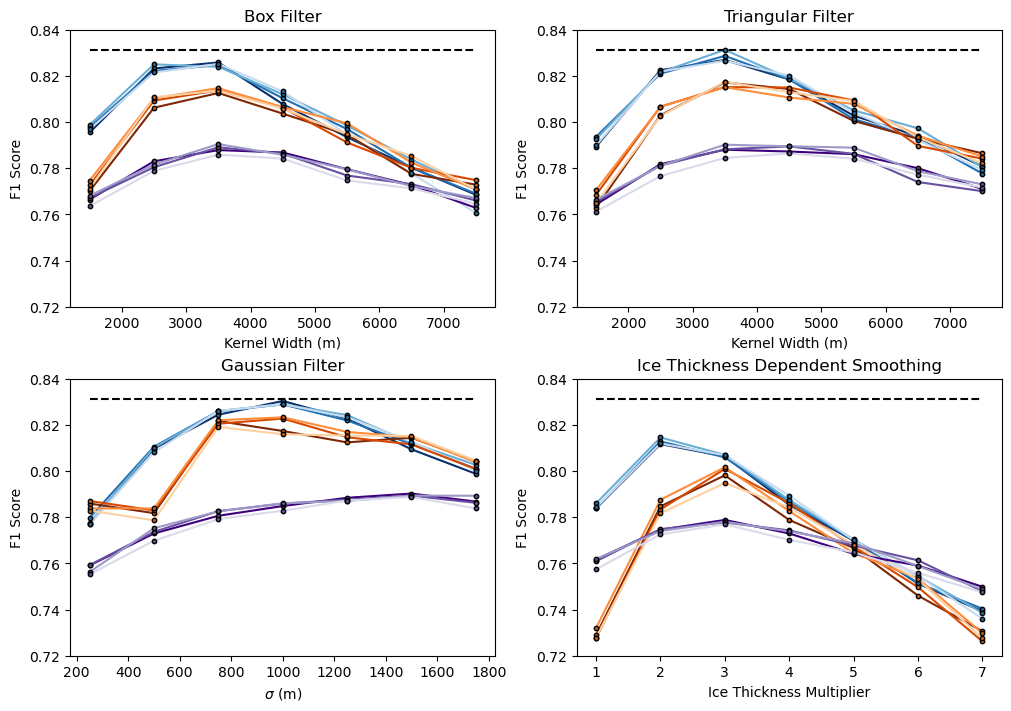

In [24]:
from matplotlib.collections import LineCollection

import pickle
with open('OptimizationResults.pickle', 'rb') as f:
    f1_results = pickle.load(f)

box = np.array([1500, 2500, 3500, 4500, 5500, 6500, 7500])
gauss = np.array([250, 500, 750, 1000, 1250, 1500, 1750])
thick = np.array([1, 2, 3, 4, 5, 6, 7])

scale = np.array([5,4,3,2,1])

fig, axs = plt.subplots(2,2, layout="constrained", figsize=(10,7))

# Generate line collection
MAvg_lines = []
M12_lines = []
ILAvg_lines = []
for i in range(f1_results.shape[2]):
    MAvg_lines.append(np.concatenate((box.reshape(-1,1), f1_results[0,0:7,i].reshape(-1,1)), axis=1))
    M12_lines.append(np.concatenate((box.reshape(-1,1), f1_results[1,0:7,i].reshape(-1,1)), axis=1))
    ILAvg_lines.append(np.concatenate((box.reshape(-1,1), f1_results[2,0:7,i].reshape(-1,1)), axis=1))
MAvg_coll = LineCollection(MAvg_lines, array=scale, cmap="Blues")
M12_coll = LineCollection(M12_lines, array=scale, cmap="Oranges")
ILAvg_coll = LineCollection(ILAvg_lines, array=scale, cmap="Purples")
axs[0, 0].add_collection(MAvg_coll)
axs[0, 0].add_collection(M12_coll)
axs[0, 0].add_collection(ILAvg_coll)
for i in range(f1_results.shape[2]):
    axs[0,0].scatter(box, f1_results[0,0:7,i], color="#1e6a9f", s=10, zorder=3, edgecolors='black')
    axs[0,0].scatter(box, f1_results[1,0:7,i], color="#d35c0b", s=10, zorder=3, edgecolors='black')
    axs[0,0].scatter(box, f1_results[2,0:7,i], color="#5c5292", s=10, zorder=3, edgecolors='black')
axs[0, 0].plot(box, 0.83126333*np.ones(box.shape), color="black", linestyle="dashed")
axs[0, 0].set_ylim((0.72, 0.84))
axs[0, 0].set_xlabel("Kernel Width (m)")
axs[0, 0].set_ylabel("F1 Score")
axs[0, 0].set_title("Box Filter")

MAvg_lines = []
M12_lines = []
ILAvg_lines = []
for i in range(f1_results.shape[2]):
    MAvg_lines.append(np.concatenate((box.reshape(-1,1), f1_results[0,7:14,i].reshape(-1,1)), axis=1))
    M12_lines.append(np.concatenate((box.reshape(-1,1), f1_results[1,7:14,i].reshape(-1,1)), axis=1))
    ILAvg_lines.append(np.concatenate((box.reshape(-1,1), f1_results[2,7:14,i].reshape(-1,1)), axis=1))
MAvg_coll = LineCollection(MAvg_lines, array=scale, cmap="Blues")
M12_coll = LineCollection(M12_lines, array=scale, cmap="Oranges")
ILAvg_coll = LineCollection(ILAvg_lines, array=scale, cmap="Purples")
axs[0, 1].add_collection(MAvg_coll)
axs[0, 1].add_collection(M12_coll)
axs[0, 1].add_collection(ILAvg_coll)
for i in range(f1_results.shape[2]):
    axs[0,1].scatter(box, f1_results[0,7:14,i], color="#1e6a9f", s=10, zorder=3, edgecolors='black')
    axs[0,1].scatter(box, f1_results[1,7:14,i], color="#d35c0b", s=10, zorder=3, edgecolors='black')
    axs[0,1].scatter(box, f1_results[2,7:14,i], color="#5c5292", s=10, zorder=3, edgecolors='black')
axs[0, 1].plot(box, 0.83126333*np.ones(box.shape), color="black", linestyle="dashed")
axs[0, 1].set_ylim((0.72, 0.84))
axs[0, 1].set_xlabel("Kernel Width (m)")
axs[0, 1].set_ylabel("F1 Score")
axs[0, 1].set_title("Triangular Filter")

MAvg_lines = []
M12_lines = []
ILAvg_lines = []
for i in range(f1_results.shape[2]):
    MAvg_lines.append(np.concatenate((gauss.reshape(-1,1), f1_results[0,14:21,i].reshape(-1,1)), axis=1))
    M12_lines.append(np.concatenate((gauss.reshape(-1,1), f1_results[1,14:21,i].reshape(-1,1)), axis=1))
    ILAvg_lines.append(np.concatenate((gauss.reshape(-1,1), f1_results[2,14:21,i].reshape(-1,1)), axis=1))
MAvg_coll = LineCollection(MAvg_lines, array=scale, cmap="Blues")
M12_coll = LineCollection(M12_lines, array=scale, cmap="Oranges")
ILAvg_coll = LineCollection(ILAvg_lines, array=scale, cmap="Purples")
axs[1, 0].add_collection(MAvg_coll)
axs[1, 0].add_collection(M12_coll)
axs[1, 0].add_collection(ILAvg_coll)
for i in range(f1_results.shape[2]):
    axs[1,0].scatter(gauss, f1_results[0,14:21,i], color="#1e6a9f", s=10, zorder=3, edgecolors='black')
    axs[1,0].scatter(gauss, f1_results[1,14:21,i], color="#d35c0b", s=10, zorder=3, edgecolors='black')
    axs[1,0].scatter(gauss, f1_results[2,14:21,i], color="#5c5292", s=10, zorder=3, edgecolors='black')
axs[1, 0].plot(gauss, 0.83126333*np.ones(box.shape), color="black", linestyle="dashed")
axs[1, 0].set_ylim((0.72, 0.84))
axs[1, 0].set_xlabel("$\sigma$ (m)")
axs[1, 0].set_ylabel("F1 Score")
axs[1, 0].set_title("Gaussian Filter")

MAvg_lines = []
M12_lines = []
ILAvg_lines = []
for i in range(f1_results.shape[2]):
    MAvg_lines.append(np.concatenate((thick.reshape(-1,1), f1_results[0,21:28,i].reshape(-1,1)), axis=1))
    M12_lines.append(np.concatenate((thick.reshape(-1,1), f1_results[1,21:28,i].reshape(-1,1)), axis=1))
    ILAvg_lines.append(np.concatenate((thick.reshape(-1,1), f1_results[2,21:28,i].reshape(-1,1)), axis=1))
MAvg_coll = LineCollection(MAvg_lines, array=scale, cmap="Blues")
M12_coll = LineCollection(M12_lines, array=scale, cmap="Oranges")
ILAvg_coll = LineCollection(ILAvg_lines, array=scale, cmap="Purples")
axs[1, 1].add_collection(MAvg_coll)
axs[1, 1].add_collection(M12_coll)
axs[1, 1].add_collection(ILAvg_coll)
for i in range(f1_results.shape[2]):
    axs[1,1].scatter(thick, f1_results[0,21:28,i], color="#1e6a9f", s=10, zorder=3, edgecolors='black')
    axs[1,1].scatter(thick, f1_results[1,21:28,i], color="#d35c0b", s=10, zorder=3, edgecolors='black')
    axs[1,1].scatter(thick, f1_results[2,21:28,i], color="#5c5292", s=10, zorder=3, edgecolors='black')
axs[1, 1].plot(thick, 0.83126333*np.ones(box.shape), color="black", linestyle="dashed")
axs[1, 1].set_ylim((0.72, 0.84))
axs[1, 1].set_xlabel("Ice Thickness Multiplier")
axs[1, 1].set_ylabel("F1 Score")
axs[1, 1].set_title("Ice Thickness Dependent Smoothing")

plt.savefig("./Figures/Optimization.svg")
plt.show()

## [6] Confusion Matrix for Example Model 

To run this section, edit Section 3 to train a single model of interest instead of the entire optimization ensemble. Then run this code block.

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_hat, normalize='true', cmap="autumn")
plt.savefig("./Figures/ConfusionMatrix.svg")
plt.show()

## [7] Regional Cross-Validation 

This code runs a five-fold regional cross-validation using the optimal method of calculating stresses. This is "Experiment 18", which used the MEASURES multi-decadal average velocities smoothed using a Gaussian filter with a 1000 m bandwidth, the Cuffey & Patterson rate factor parameterization, and the mean anuual RACMO surface temperatures. Regional folds are defined as in Figure 1 of the main text. 

In [4]:
strain_dir_w = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\StrainRate\\"
strain_dir_e = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\StrainRateNE\\"
temp_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\RACMOTraining\\"
crev_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\TrainingData\\"
test_dir =  "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\TestSet\\"
val_dir = "C:\\Users\\rtc84\\Documents\\Data\\Greenland\\Crevasses\\IceSlabCrevasseData\\TestSet\\"

strain_experiments = ["Exp18"]
velocity_maps = ["MAvg"]
temp_maps = ["Annual"]

# Cuffey and Patterson Constants for Ice Viscosity Model
A_star = 3.5e-25        # Pa^-3s^-1
T_start = 263.0         # K
R = 8.314               # J mol^-1 K^-1
Qc = 60e3               # J mol^-1
Qc2 = 115e3             # J mol^-1
n = 3.

# Cross-validation parameters
n_folds = 5

f1_crossval = np.zeros(n_folds)
for i in velocity_maps:
    for j in strain_experiments:
        # Set file locations for the strain rate for the west coast
        eXX_file_w = strain_dir_w+j+"_eXX_"+i+".tif"
        eYY_file_w = strain_dir_w+j+"_eYY_"+i+".tif"
        eXY_file_w = strain_dir_w+j+"_eXY_"+i+".tif"

        # Read in all three components of the strain rate for the west coast
        dataset = rio.open(eXX_file_w)
        eXX_w = dataset.read(1)
        dataset.close()
        dataset = rio.open(eYY_file_w)
        eYY_w = dataset.read(1)
        dataset.close()
        dataset = rio.open(eXY_file_w)
        eXY_w = dataset.read(1)
        dataset.close()

        # Set file locations for the strain rate for the east coast
        eXX_file_e = strain_dir_e+j+"_eXX_"+i+".tif"
        eYY_file_e = strain_dir_e+j+"_eYY_"+i+".tif"
        eXY_file_e = strain_dir_e+j+"_eXY_"+i+".tif"

        # Read in all three components of the strain rate for the east coast
        dataset = rio.open(eXX_file_e)
        eXX_e = dataset.read(1)
        dataset.close()
        dataset = rio.open(eYY_file_e)
        eYY_e = dataset.read(1)
        dataset.close()
        dataset = rio.open(eXY_file_e)
        eXY_e = dataset.read(1)
        dataset.close()

        # Mask out regions of no data in the 2012-2013 strain rate maps
        if i == "M12":
            eXX_w = eXX_w*vel_mask_w
            eYY_w = eYY_w*vel_mask_w
            eXY_w = eXY_w*vel_mask_w
            eXX_e = eXX_e*vel_mask_e
            eYY_e = eYY_e*vel_mask_e
            eXY_e = eXY_e*vel_mask_e

        for k in temp_maps:
            # Find the desired temperature field at the appropriate resolution
            if i == "MAvg":
                temp_file_w = temp_dir+"Clip_RACMO"+k+"_250m.tif"
                temp_file_e = temp_dir+"NE_RACMO"+k+"_250m.tif"
                crev_file_w = crev_dir+"Clip_CrevasseMask_250m.tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_250m.tif"
                nocrev_file_w = crev_dir+"Clip_NoCrevasseMask_Full_250m.tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_250m.tif"
                test_file_e = test_dir+"NE_TestSet_250m.tif"
                test_file_w = test_dir+"W_TestSet_250m.tif"
                val_file_e =  test_dir+"NE_KFold_250m.tif"
                val_file_w =  test_dir+"W_KFold_250m.tif"
            elif i == "M12":
                temp_file_w = temp_dir+"Clip_RACMO"+k+"_500m.tif"
                temp_file_e = temp_dir+"NE_RACMO"+k+"_500m.tif"
                crev_file_w = crev_dir+"Clip_CrevasseMask_500m.tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_500m.tif"
                nocrev_file_w = crev_dir+"Clip_NoCrevasseMask_Full_500m.tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_500m.tif"
                test_file_e = test_dir+"NE_TestSet_500m.tif"
                test_file_w = test_dir+"W_TestSet_500m.tif"
                val_file_e =  test_dir+"NE_KFold_500m.tif"
                val_file_w =  test_dir+"W_KFold_500m.tif"
            elif i == "ILAvg":
                temp_file_w = temp_dir+"Clip_RACMO"+k+"_240m.tif"
                temp_file_e = temp_dir+"NE_RACMO"+k+"_240m.tif"
                crev_file_w = crev_dir+"Clip_CrevasseMask_240m.tif"
                crev_file_e = crev_dir+"NE_CrevasseMask_240m.tif"
                nocrev_file_w = crev_dir+"Clip_NoCrevasseMask_Full_240m.tif"
                nocrev_file_e = crev_dir+"NE_NoCrevasseMask_240m.tif"
                test_file_e = test_dir+"NE_TestSet_240m.tif"
                test_file_w = test_dir+"W_TestSet_240m.tif"
                val_file_e =  test_dir+"NE_KFold_240m.tif"
                val_file_w =  test_dir+"W_KFold_240m.tif"

            # Load data for the west coast temperature field
            dataset = rio.open(temp_file_w)
            temp_w = dataset.read(1)
            dataset.close()
            # Load crevasse mask for west coast
            dataset = rio.open(crev_file_w)
            crevasses_w = dataset.read(1)
            dataset.close()
            # Load no crevasse mask for west coast
            dataset = rio.open(nocrev_file_w)
            no_crevasses_w = dataset.read(1)
            dataset.close()
            # Load test set for west coast
            dataset = rio.open(test_file_w)
            test_w = dataset.read(1)
            dataset.close()
            # Load cross validation test sets for west coast
            dataset = rio.open(val_file_w)
            val_w = dataset.read(1)
            dataset.close()

            # Load data for the east coast temperature field
            dataset = rio.open(temp_file_e)
            temp_e = dataset.read(1)
            dataset.close()
            # Load crevasse mask for east coast
            dataset = rio.open(crev_file_e)
            crevasses_e = dataset.read(1)
            dataset.close()
            # Load no crevasse mask for east coast
            dataset = rio.open(nocrev_file_e)
            no_crevasses_e = dataset.read(1)
            dataset.close()
             # Load test set for east coast
            dataset = rio.open(test_file_e)
            test_e = dataset.read(1)
            dataset.close()
             # Load cross validation test sets for east coast
            dataset = rio.open(val_file_e)
            val_e = dataset.read(1)
            dataset.close()

            crevasses_w = np.matrix.flatten(crevasses_w.astype("float64"))
            crevasses_e = np.matrix.flatten(crevasses_e.astype("float64"))
            crevasses = np.concatenate((crevasses_w, crevasses_e), axis=0)
            no_crevasses_w = np.matrix.flatten(no_crevasses_w.astype("float64"))
            no_crevasses_e = np.matrix.flatten(no_crevasses_e.astype("float64"))
            no_crevasses = np.concatenate((no_crevasses_w, no_crevasses_e), axis=0)
            test_w = np.matrix.flatten(test_w.astype("float64"))
            test_e = np.matrix.flatten(test_e.astype("float64"))
            test = np.concatenate((test_w, test_e), axis=0)
            val_w = np.matrix.flatten(val_w.astype("float64"))
            val_e = np.matrix.flatten(val_e.astype("float64"))
            val = np.concatenate((val_w, val_e), axis=0)

            # Combine flattened strain rate matrices for both regions (east and west)
            eXX_comb = np.concatenate((np.matrix.flatten(eXX_w), np.matrix.flatten(eXX_e)), axis=0)
            eXY_comb = np.concatenate((np.matrix.flatten(eXY_w), np.matrix.flatten(eXY_e)), axis=0)
            eYY_comb = np.concatenate((np.matrix.flatten(eYY_w), np.matrix.flatten(eYY_e)), axis=0)

            # Combine flattened temperature information for both regions (east and west)
            temp_comb = np.concatenate((np.matrix.flatten(temp_w), np.matrix.flatten(temp_e)), axis=0)

            # Extract strain rates in crevassed and uncrevassed regions
            eXX_crev = eXX_comb[crevasses == 1]
            eXX_nocrev = eXX_comb[no_crevasses == 1]
            eXY_crev = eXY_comb[crevasses == 1]
            eXY_nocrev = eXY_comb[no_crevasses == 1]
            eYY_crev = eYY_comb[crevasses == 1]
            eYY_nocrev = eYY_comb[no_crevasses == 1]

            # Extract temperatures for crevassed and uncrevassed regions
            temp_crev = temp_comb[crevasses == 1]
            temp_nocrev = temp_comb[no_crevasses == 1]

            # Extract test set for crevassed and uncrevassed regions
            test_crev = test[crevasses == 1]
            test_nocrev = test[no_crevasses == 1]

            # Extract cross=validation set for crevassed and uncrevassed regions
            val_crev = val[crevasses == 1]
            val_nocrev = val[no_crevasses == 1]

            # Merge into a single vectors for all variables of interest
            eXX = np.concatenate((eXX_crev, eXX_nocrev), axis=0)
            eXY = np.concatenate((eXY_crev, eXY_nocrev), axis=0)
            eYY = np.concatenate((eYY_crev, eYY_nocrev), axis=0)
            temp = np.concatenate((temp_crev,  temp_nocrev), axis=0)
            test_set = np.concatenate((test_crev,  test_nocrev), axis=0)
            val_set = np.concatenate((val_crev, val_nocrev), axis=0)

            # Convert temperature field to degrees Kelvin
            temp = temp + 273.15

            # Calculate creep coefficient with temperature dependence of activation energy on west coast
            A = np.zeros(temp.shape)
            for p in range(0,temp.shape[0]):
                if temp[p] > 273.15:
                    temp[p] = 273.15
                    A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                elif temp[p] > 263.0:
                    A[p] = A_star*np.exp((-Qc2/R)*((1/temp[p]) - (1/T_start)))
                else:
                    A[p] = A_star*np.exp((-Qc/R)*((1/temp[p]) - (1/T_start)))

            # Convert strain rates from 1/yr to 1/s
            eXX_s = eXX*(1/(60*60*24*365))
            eXY_s = eXY*(1/(60*60*24*365))
            eYY_s = eYY*(1/(60*60*24*365))

            #Calculate effective stress
            eE = np.sqrt(0.5*(eXX_s**2 + eYY_s**2 + (-eXX_s - eYY_s)**2) + eXY_s**2)

            # Calculate deviatoric stress at surface
            tau_xx = (A**(-1/n))*(eE**((1-n)/n))*eXX_s
            tau_yy = (A**(-1/n))*(eE**((1-n)/n))*eYY_s
            tau_xy = (A**(-1/n))*(eE**((1-n)/n))*eXY_s 

            # Calculate full Cauchy stress at surface
            sigma_xx = 2.*tau_xx + tau_yy
            sigma_yy = 2.*tau_yy + tau_xx

            # Calculate principal stresses
            sigma1 = 0.5*(sigma_xx + sigma_yy) + np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)
            sigma2 = 0.5*(sigma_xx + sigma_yy) - np.sqrt((0.5*(sigma_xx - sigma_yy))**2 + tau_xy**2)

            # Von Mises Stress over whole area of interest
            sigmaV = np.sqrt(sigma1**2 - sigma1*sigma2 + sigma2**2)

            # Make the label set
            label = np.concatenate((np.ones(temp_crev.shape), np.zeros(temp_nocrev.shape)), axis=0)

            # Remove regions of pure compression, because we will automatically predict no fracture there
            stress = sigmaV[sigma1 > 0.]
            test_set = test_set[sigma1 > 0.]
            val_set = val_set[sigma1 > 0.]
            compression_label = label[sigma1 <= 0.]
            label = label[sigma1 > 0.]
            
            # Clean up edge case problems for the M12 data with a bunch of gaps
            if i == "M12":
                val_set = val_set[stress < 500000.]
                test_set = test_set[stress < 500000.]
                label = label[stress < 500000.]
                stress = stress[stress < 500000.]

            for k in range(0, n_folds):

                # Select the kth fold as the test set and leave the remaining data for training
                test_fold = val_set
                test_fold[test_fold < k] = 0
                test_fold[test_fold > k] = 0
                test_fold[test_fold == k] = 1
                
                # Test-train split once optimized
                stress_train,stress_test,label_train,label_test=train_test_split(stress.reshape(-1,1),label,stratify=test_fold)

                # Instantiate and train the model
                regress = LogisticRegression(class_weight="balanced")
                regress.fit(stress_train,label_train)

                # Choose the optimal discrimination threshold on the training data set
                prob = regress.predict_proba(stress_train)
                precision, recall, thresholds = metrics.precision_recall_curve(label_train, prob[:,1])
                # convert to f score
                fscore = (2 * precision * recall) / (precision + recall)
                fscore[np.isnan(fscore)] = 0
                # locate the index of the largest f score
                ix = np.argmax(fscore)
                print('Best Threshold=%f' % (thresholds[ix]))

                # Calculate crevasse predictions on test set with optimized discrimination threshold
                prob = regress.predict_proba(stress_test)
                y_hat = np.zeros(prob[:,1].shape)
                y_hat[prob[:,1] >= thresholds[ix]] = 1
                # Reincorporate regions of pure compression which we automatically assign to be no crevasse
                y_hat = np.concatenate((y_hat, np.zeros(compression_label.shape)), axis=0)
                y_test = np.concatenate((label_test, compression_label), axis=0)
                fscore = metrics.f1_score(y_test, y_hat, average="weighted")
                print('Fold # %.1f F-Score=%.3f' % (k, fscore))

                # Save the f1 score on the current test fold
                f1_crossval[k] = fscore


Best Threshold=0.342864
Fold # 0.0 F-Score=0.827
Best Threshold=0.348488
Fold # 1.0 F-Score=0.828
Best Threshold=0.354751
Fold # 2.0 F-Score=0.826
Best Threshold=0.340496
Fold # 3.0 F-Score=0.829
Best Threshold=0.338730
Fold # 4.0 F-Score=0.827
